# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OrdinalEncoder 
from lightgbm import LGBMRegressor

import lightgbm as lgb

from sklearn.metrics import mean_squared_error

In [3]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [6]:
display(data.head())
print("Размер таблицы", data.shape)
print("Дублей:", data.duplicated().sum())
print(data.info())
print(data.isnull().sum())
print(data.describe())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Размер таблицы (354369, 16)
Дублей: 4
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB
None
DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear 

In [7]:
#избавимся от дубликатов, преобразуем соответствующие данные в формат даты

#display(data.loc[data.duplicated(keep=False)])
data = data.drop_duplicates().reset_index(drop=True)
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'], format= '%Y-%m-%d %H:%M:%S')
data['DateCreated'] = pd.to_datetime(data['DateCreated'], format= '%Y-%m-%d %H:%M:%S')
data['LastSeen'] = pd.to_datetime(data['LastSeen'], format= '%Y-%m-%d %H:%M:%S')

In [8]:
#посмотрим уникальные значения в столбцах с пропущенными значениями (и не только)

print("VehicleType:", data['VehicleType'].unique())
print("Gearbox:", data['Gearbox'].unique())
#print("Model:", data['Model'].unique())
print("Model count:", len(data['Model'].unique()))
print("FuelType:", data['FuelType'].unique())
print("NotRepaired:", data['NotRepaired'].unique())
print("NumberOfPictures:", data['NumberOfPictures'].unique())
print("PostalCode count:", len(data['PostalCode'].unique()))
print("Price=0 count:", len(data.query('Price==0')))
print('RegistrationYear:')
print("max", data['RegistrationYear'].max())
print(data['RegistrationYear'].value_counts())

VehicleType: [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Gearbox: ['manual' 'auto' nan]
Model count: 251
FuelType: ['petrol' 'gasoline' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']
NotRepaired: [nan 'yes' 'no']
NumberOfPictures: [0]
PostalCode count: 8143
Price=0 count: 10772
RegistrationYear:
max 9999
2000    24490
1999    22727
2005    22109
2001    20123
2006    19900
        ...  
3200        1
1920        1
1919        1
1915        1
8455        1
Name: RegistrationYear, Length: 151, dtype: int64


In [9]:
# заполним пропуски unknown, удалим столбец NumberOfPictures, т.к. везде одно значение
nan_list = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']
for i in nan_list:
    data[i] = data[i].fillna('unknown')
    
data['yearcreated'] = pd.DatetimeIndex(data['DateCreated']).year
data['monthcreated'] = pd.DatetimeIndex(data['DateCreated']).month

data = data.drop(['NumberOfPictures', 'LastSeen', 'DateCrawled', "DateCreated"], axis = 1)
data = data.query('Price!=0')


In [10]:
# исправляем нереальные значения RegistrationYear

now_year = 2020
data = data.query('RegistrationYear<=2020')

mean_year = data['RegistrationYear'].mean()
sigma = np.std(data['RegistrationYear'])
# возьмем не 3 а 4 сигмы, тк возможно выбросы это не аномальные значения, а, например, раритетные машины.
last_year = int(mean_year - 4 *sigma) 
print(len(data.query('RegistrationYear < @last_year')))
data = data.query('RegistrationYear >= @last_year')

179


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,PostalCode,yearcreated,monthcreated
Price,1.000000,0.384775,0.160999,-0.352079,0.097540,0.071609,-0.005377,0.014747
RegistrationYear,0.384775,1.000000,0.034039,-0.200405,0.037364,0.022088,-0.000500,0.001970
Power,0.160999,0.034039,1.000000,0.021371,0.038338,0.020805,0.000100,0.002897
Kilometer,-0.352079,-0.200405,0.021371,1.000000,0.000244,-0.009368,0.004846,-0.002141
RegistrationMonth,0.097540,0.037364,0.038338,0.000244,1.000000,0.009745,0.003522,-0.002381
PostalCode,0.071609,0.022088,0.020805,-0.009368,0.009745,1.000000,0.000660,0.010177
yearcreated,-0.005377,-0.000500,0.000100,0.004846,0.003522,0.000660,1.000000,-0.151228
monthcreated,0.014747,0.001970,0.002897,-0.002141,-0.002381,0.010177,-0.151228,1.000000


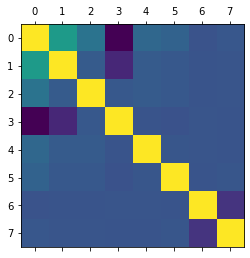

In [12]:
#посмтроим матрицу диаграмм рассеяния
display(data.corr())
#pd.plotting.scatter_matrix(data, figsize = (16,16))
plt.show()

plt.matshow(data.corr())
plt.show()

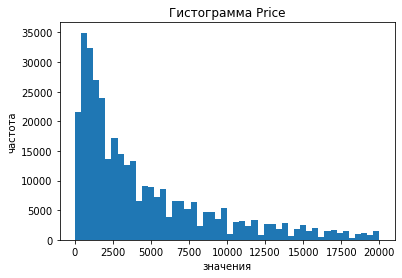

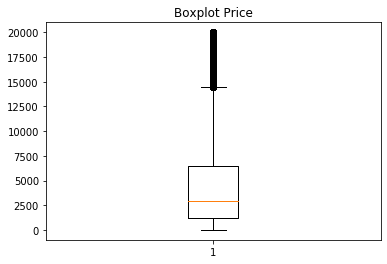

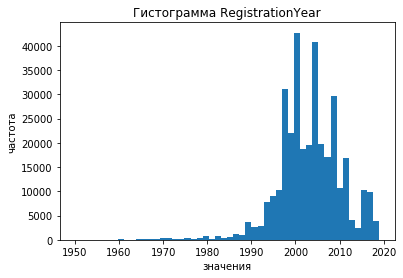

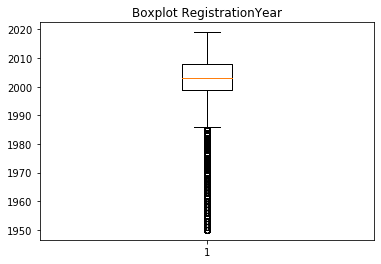

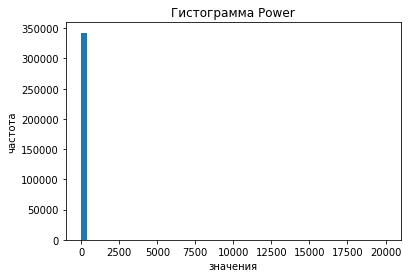

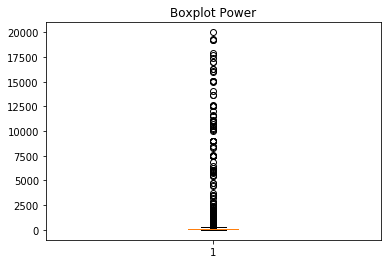

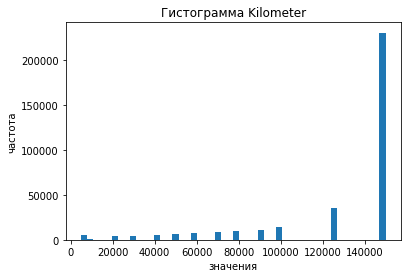

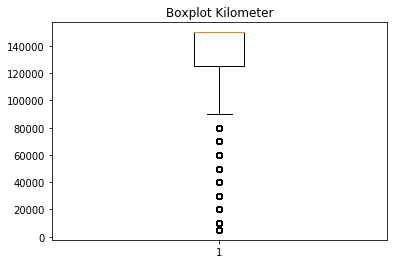

In [13]:
# посмотрим выбросы
hist_list = ['Price', 'RegistrationYear', 'Power', 'Kilometer']
for i in hist_list:
    plt.hist(data[i], bins=50)
    plt.title(f"Гистограмма {i}")
    plt.xlabel("значения")
    plt.ylabel("частота")
    plt.show()
    
    plt.boxplot(data[i])
    plt.title(f"Boxplot {i}")
    plt.show()

In [14]:
# разберемся с выбросами в столбце Power
#print(data['Power'].describe())

mean_power = data['Power'].mean()
sigma = np.std(data['Power'])
max_power = int(mean_power + 3 *sigma) 
print(len(data.query('Power > @max_power')))
display(data.query('Power > @max_power').head())

326


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode,yearcreated,monthcreated
1816,3200,small,2004,manual,1398,corolla,5000,6,petrol,toyota,no,22043,2016,3
4060,3100,sedan,2005,manual,953,colt,150000,4,gasoline,mitsubishi,no,60326,2016,4
5328,500,wagon,1999,manual,1001,astra,150000,7,petrol,opel,unknown,33154,2016,3
6504,3000,small,2009,manual,771,punto,125000,0,petrol,fiat,unknown,40721,2016,3
7661,1499,small,1999,manual,7515,lupo,150000,4,petrol,volkswagen,unknown,65830,2016,4


In [15]:
#удалим выбросы в столбце Power
data = data.query('Power <= @max_power')

In [16]:
#еще раз посмтроим на коэф. кор. и после удаления выбросов
display(data.corr())

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,PostalCode,yearcreated,monthcreated
Price,1.000000,0.384842,0.489803,-0.352286,0.097536,0.071560,-0.005376,0.014698
RegistrationYear,0.384842,1.000000,0.104448,-0.200666,0.037434,0.022118,-0.000500,0.001877
Power,0.489803,0.104448,1.000000,0.078311,0.117570,0.072695,-0.000169,0.005494
Kilometer,-0.352286,-0.200666,0.078311,1.000000,0.000298,-0.009446,0.004850,-0.002234
RegistrationMonth,0.097536,0.037434,0.117570,0.000298,1.000000,0.009713,0.003525,-0.002383
PostalCode,0.071560,0.022118,0.072695,-0.009446,0.009713,1.000000,0.000662,0.010227
yearcreated,-0.005376,-0.000500,-0.000169,0.004850,0.003525,0.000662,1.000000,-0.151304
monthcreated,0.014698,0.001877,0.005494,-0.002234,-0.002383,0.010227,-0.151304,1.000000


In [17]:
data = data.drop(['PostalCode', 'yearcreated', 'monthcreated', 'RegistrationMonth'], axis=1)
print(data.shape)

(343002, 10)


### Вывод:
Я загрузила таблицу с данными по продаже автомобилей. Датасет состоит из 354369 строки и 16 колонок. Типы колонок корректны, кроме колонок с датами. Данные в колонках DateCrawled, DateCreated, LastSeen я перевела в формат даты. Удалила дубликаты (4 шт.). Пропуски в столюцах с категориальными данными, их я заполнила значением "unknown", чтобы измежать влияния на обучение моделей. Я добавила колонку год и месяц взяв данные из DateCreated и удалила столбцы NumberOfPictures, LastSeen, DateCrawled, DateCreated. Я также удалила примеры, где цена машины равна 0. В части данных были выбросы, я применима правило 3 сигм, чтобы избавиться от выбросов в колонках RegistrationYear и Power. Также проанализиров коэффициенты корреляции между ценой и другими признаками я дополнительно удалила столбцы 'PostalCode', 'yearcreated', 'monthcreated', 'RegistrationMonth', чтобы "облегчить" таблицу. Эти данные практически не влияли на цену.

## Обучение моделей

In [18]:
def split(data):
    features = data.drop(['Price'], axis = 1)
    target = data['Price']
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size = 0.4, random_state = 123)
    features_test, features_valid, target_test, target_valid = train_test_split(features_valid, target_valid, test_size = 0.5, random_state = 123)
    return features_train, features_valid, features_test, target_train, target_valid, target_test

In [19]:
# DummyClassifier проверка модели на адекватность
data_ohe = pd.get_dummies(data, drop_first=True)
features_train, features_valid, features_test, target_train, target_valid, target_test = split(data_ohe)

print("Результаты модели DummyRegressor (проверка модели на адекватность)")
model = DummyRegressor(strategy='median')
%time model.fit(features_train, target_train)
predicted = model.predict(features_valid)
mse = mean_squared_error(target_valid, predicted)
print("RMSE:", mse ** 0.5)

Результаты модели DummyRegressor (проверка модели на адекватность)
CPU times: user 3.49 ms, sys: 347 µs, total: 3.84 ms
Wall time: 6.14 ms
RMSE: 4783.16489375084


In [20]:
# LinearRegression
data_ohe = pd.get_dummies(data, drop_first=True)
features_train, features_valid, features_test, target_train, target_valid, target_test = split(data_ohe)

print("Результаты модели LinearRegression")
model = LinearRegression()
%time model.fit(features_train, target_train)
predicted = model.predict(features_valid)
mse = mean_squared_error(target_valid, predicted)
print("RMSE:", mse ** 0.5)

Результаты модели LinearRegression
CPU times: user 18.1 s, sys: 8.43 s, total: 26.6 s
Wall time: 26.7 s
RMSE: 2705.8330889447248


In [21]:
#RandomForestRegressor

features_train, features_valid, features_test, target_train, target_valid, target_test = split(data)
encoder = OrdinalEncoder()
features_train = pd.DataFrame(encoder.fit_transform(features_train), columns=features_train.columns)
features_valid = pd.DataFrame(encoder.fit_transform(features_valid), columns=features_valid.columns)

print("Результаты модели RandomForestRegressor")
model = RandomForestRegressor(n_estimators=46, max_depth = 21, random_state = 123)
%time model.fit(features_train, target_train)
predicted = model.predict(features_valid)
mse = mean_squared_error(target_valid, predicted)
print("RMSE:", mse ** 0.5)

Результаты модели RandomForestRegressor
CPU times: user 24.5 s, sys: 0 ns, total: 24.5 s
Wall time: 24.8 s
RMSE: 2742.7320752281485


#код для подбора параметров RandomForestRegressor

encoder = OrdinalEncoder()
data_ordinal = pd.DataFrame(encoder.fit_transform(data), columns=data.columns)
features_train, features_valid, features_test, target_train, target_valid, target_test = split(data_ordinal)

n_estimatots = 0
max_depth = 0
best_score = 5000
for i in range(1,50,5):
    for j in range(1,50,5):
        model = RandomForestRegressor(random_state = 123, max_depth=i, n_estimators = j)
        model.fit(features_train, target_train)
        predicted = model.predict(features_valid)
        mse = mean_squared_error(target_valid, predicted)
        RMSE = mse** 0.5
        if best_score>RMSE:
            best_score=RMSE
            max_depth = i
            n_estimators = j

model = RandomForestRegressor(n_estimators=n_estimators, max_depth = max_depth, random_state = 123)
model.fit(features_train, target_train)
predicted = model.predict(features_valid)
mse = mean_squared_error(target_valid, predicted)
print("Результаты модели model_RandomForestRegressor")
print("RMSE:", mse ** 0.5)
print("Лучшая глубина:", max_depth, "   |   Лучшее кол-во деревьев:", n_estimators)

In [22]:
# CatBoostClassifier
features_train, features_valid, features_test, target_train, target_valid, target_test = split(data)
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

print("Результаты модели CatBoostRegressor")
model = CatBoostRegressor(iterations = 46, depth = 13, learning_rate = 0.7, random_state=123)
%time model.fit(features_train, target_train, cat_features=cat_features, verbose=False)
predicted = model.predict(features_valid)
mse = mean_squared_error(target_valid, predicted)
print("RMSE:", mse ** 0.5)

Результаты модели CatBoostRegressor
CPU times: user 33.3 s, sys: 3.9 s, total: 37.2 s
Wall time: 38.7 s
RMSE: 1663.5234042723985


#код для подбора параметров CatBoostClassifier

features_train, features_valid, features_test, target_train, target_valid, target_test = split(data)
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

itera = 0
max_depth = 0
best_score = 5000
for i in range(1,50,5):
    for j in range(1,16,3):
        model = CatBoostRegressor(iterations = i, depth = j, learning_rate = 0.7, random_state=123)
        model.fit(features_train, target_train, cat_features=cat_features, verbose = False)
        predicted = model.predict(features_valid)
        mse = mean_squared_error(target_valid, predicted)
        RMSE = mse** 0.5
        if best_score>RMSE:
            best_score=RMSE
            max_depth = j
            itera = i

model = CatBoostRegressor(iterations=itera, max_depth = j, learning_rate = 0.7, random_state = 123)
model.fit(features_train, target_train, cat_features=cat_features, verbose = False)
predicted = model.predict(features_valid)
mse = mean_squared_error(target_valid, predicted)
print("Результаты модели CatBoostClassifier")
print("RMSE:", mse ** 0.5)
print("Лучшая глубина:", max_depth, "   |   Лучшее кол-во деревьев:", itera)
%time

In [23]:
# LGBMRegressor

features_train, features_valid, features_test, target_train, target_valid, target_test = split(data)
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
for col_name in cat_features:
    features_train[col_name] = features_train[col_name].astype('category')
    features_valid[col_name] = features_valid[col_name].astype('category')

print("Результаты модели LGBMRegressor")
model = LGBMRegressor(max_depth=11, n_estimators =46, random_state = 123)
%time model.fit(features_train, target_train, categorical_feature = cat_features)
predicted = model.predict(features_valid)
mse = mean_squared_error(target_valid, predicted)
print("RMSE:", mse ** 0.5)

Результаты модели LGBMRegressor


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


CPU times: user 4.08 s, sys: 3.8 ms, total: 4.08 s
Wall time: 4.11 s
RMSE: 1730.978485815574


#код для подбора параметров LGBMRegressor

encoder = OrdinalEncoder()
data_ordinal = pd.DataFrame(encoder.fit_transform(data), columns=data.columns)
features_train, features_valid, features_test, target_train, target_valid, target_test = split(data_ordinal)
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

itera = 0
max_depth = 0
best_score = 5000
for i in range(1,50,5):
    for j in range(1,31,5):
        model = LGBMRegressor(n_estimators =i, max_depth = j, random_state = 123)
        model.fit(features_train, target_train, categorical_feature = cat_features)
        predicted = model.predict(features_valid)
        mse = mean_squared_error(target_valid, predicted)
        RMSE = mse** 0.5
        if best_score>RMSE:
            best_score=RMSE
            max_depth = j
            itera = i

model = LGBMRegressor(n_estimators =itera, max_depth = j, random_state = 123)
model.fit(features_train, target_train, categorical_feature = cat_features)
predicted = model.predict(features_valid)
mse = mean_squared_error(target_valid, predicted)
print("Результаты модели LGBMRegressor")
print("RMSE:", mse ** 0.5)
print("Лучшая глубина:", max_depth, "   |   Лучшее кол-во деревьев:", itera)
%time

### Вывод:
Для обучения и проверки я поделила датасет на обучающую, валидационную и тестовую выборки (в пропорции 3:1:1). Целевой признак Price. Для оценка качества моелей я использовала метрику RMSE. Модели показали сл. результаты в предсказании цен на машины:

DummyClassifier: 4783

LinearRegression: 2705

RandomForestRegressor (n_estimators=46, max_depth = 21): 2742

CatBoostClassifier (iterations = 46, depth = 13, learning_rate = 0.7): 1663

LGBMRegressor (max_depth=11, n_estimators =46): 1730

Самой точной оказалась модель: CatBoostClassifier (RMSE = 1663, время работы 38 сек). А самой быстрой с хорошей точностью LGBMRegressor (RMSE = , время обучения 4 сек). Проверим эти две модели на тестовых данных.

## Анализ моделей

In [25]:
# CatBoostClassifier
features_train, features_valid, features_test, target_train, target_valid, target_test = split(data)
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

print("Результаты модели CatBoostRegressor")
model = CatBoostRegressor(iterations = 46, depth = 13, learning_rate = 0.7, random_state=123)
%time model.fit(features_train, target_train, cat_features=cat_features, verbose=False)
%time predicted = model.predict(features_test)
mse = mean_squared_error(target_test, predicted)
print("RMSE:", mse ** 0.5)

Результаты модели CatBoostRegressor
CPU times: user 33 s, sys: 3.39 s, total: 36.4 s
Wall time: 37.5 s
CPU times: user 198 ms, sys: 0 ns, total: 198 ms
Wall time: 173 ms
RMSE: 1694.3082359812727


In [28]:
# LGBMRegressor

features_train, features_valid, features_test, target_train, target_valid, target_test = split(data)
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
for col_name in cat_features:
    features_train[col_name] = features_train[col_name].astype('category')
    features_test[col_name] = features_test[col_name].astype('category')

print("Результаты модели LGBMRegressor")
model = LGBMRegressor(max_depth=11, n_estimators =46, random_state = 123)
%time model.fit(features_train, target_train, categorical_feature = cat_features)
%time predicted = model.predict(features_test)
mse = mean_squared_error(target_test, predicted)
print("RMSE:", mse ** 0.5)

Результаты модели LGBMRegressor


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


CPU times: user 3.99 s, sys: 7.71 ms, total: 4 s
Wall time: 4.04 s
CPU times: user 461 ms, sys: 0 ns, total: 461 ms
Wall time: 495 ms
RMSE: 1759.5226450441758


In [27]:
# DummyClassifier проверка модели на адекватность
data_ohe = pd.get_dummies(data, drop_first=True)
features_train, features_valid, features_test, target_train, target_valid, target_test = split(data_ohe)

print("Результаты модели DummyRegressor (проверка модели на адекватность)")
model = DummyRegressor(strategy='median')
%time model.fit(features_train, target_train)
predicted = model.predict(features_test)
mse = mean_squared_error(target_test, predicted)
print("RMSE:", mse ** 0.5)

Результаты модели DummyRegressor (проверка модели на адекватность)
CPU times: user 3.89 ms, sys: 0 ns, total: 3.89 ms
Wall time: 3.51 ms
RMSE: 4805.212885047532


### Вывод:
На тестовых данных модель CatBoostClassifier с параметрами iterations = 46, depth = 13, learning_rate = 0.7 показала хорошее качество: RMSE = 1694.LGBMRegressor с параметрами max_depth=11, n_estimators =46 показала хорошее качество: RMSE = 1759. Результат у CatBoostClassifier немного лучше, чем у LGBMRegressor;
CatBoostClassifier обучается в 9 раз медленнее LGBMRegressor (на 33 секунды);
CatBoostClassifier прогнозирует в 3 раза быстрее LGBMRegressor.

Учитывая скорость работы и качество моделей рекомендую к использованию модель LGBMRegressor при единоразовом использовании/прогнозировании результатов и CatBoostClassifier при перманентном/онлайн прогнозирования, т.е. когда не нужно каждый раз обучать модель перед прогнозом.